In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random
from tensorflow import keras
from pathlib import Path
from gaussian_blur import apply_gaussian_blur
import json
from utils import TrainUtils
print(tf.__version__)

2.19.0


In [3]:
img_height=64
img_width=64
batch_size=32
data_dir = "/Users/sam/dataset/icon-dataset-main/data"

#用这个集合来验证一下看看
data_dir2 = "/Users/sam/dataset/material_icon"



In [4]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 142416 files belonging to 100 classes.
Using 113933 files for training.


2025-06-15 19:37:04.643088: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-15 19:37:04.643117: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-15 19:37:04.643127: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1749987424.643485 13016184 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749987424.643819 13016184 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 142416 files belonging to 100 classes.
Using 28483 files for validation.


In [66]:
#重新对图片进行预处理
#resize 转灰度 高斯模糊 

def preprocess_data(images, labels):
    images = tf.image.resize(images, [img_height, img_width])
    images = tf.image.rgb_to_grayscale(images)

    #归一化
    images = tf.image.convert_image_dtype(images, tf.float32)
 
    #高斯模糊 
    images = apply_gaussian_blur(images, kernel_size=3, sigma=1)

    #二值化 效果一般 暂时不使用

    #这不能做squeeze 会丢失shape
    #images = tf.squeeze(images)
    return images, labels

preprocess_ds = train_ds.map(preprocess_data)
prepproces_val_ds = val_ds.map(preprocess_data)

print(preprocess_ds.element_spec)


(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [64]:
# 获取基数
cardinality = preprocess_ds.cardinality()

if cardinality == tf.data.INFINITE_CARDINALITY:
    print("无限数据集")
elif cardinality == tf.data.UNKNOWN_CARDINALITY:
    print("数据集大小未知")
else:
    data_size = cardinality.numpy()

data_cnt = data_size*batch_size
print(f"数据集大小: {data_cnt}")

数据集大小: 113952


(32, 64, 64, 1)
(32,)


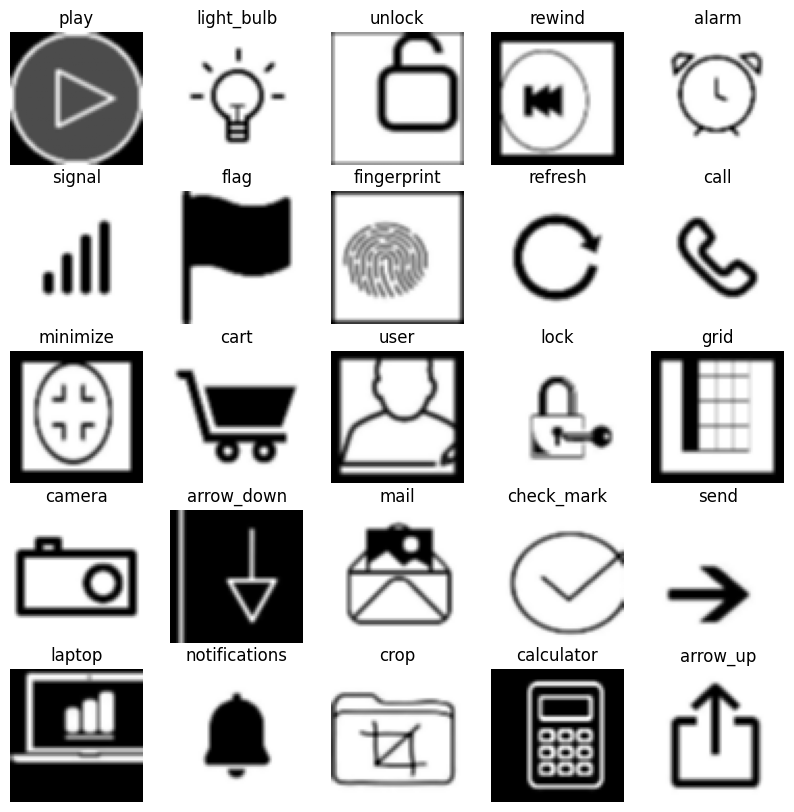

In [67]:
images, labels = next(iter(preprocess_ds))

print(images.shape)
print(labels.shape)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [31]:
num_classes=len(train_ds.class_names)
model = tf.keras.Sequential([
    # 输入层
    tf.keras.layers.Input(shape=(img_height, img_width, 1)),
    
    # 第一个卷积块
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第二个卷积块
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第三个卷积块
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 全连接层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 使用Adam优化器，添加学习率衰减
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 4,536,388 (17.30 MB)

 Trainable params: 4,534,468 (17.30 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [32]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, acc=0.95):
        super().__init__()
        self.acc = acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= self.acc:
            print(f"\n达到{self.acc*100:.2f}%准确率，停止训练。")
            self.model.stop_training = True


#训练达到90%准确率时停止
history = model.fit(preprocess_ds, validation_data=prepproces_val_ds, 
                        epochs=15, callbacks=[MyThresholdCallback(acc=0.85)], 
                        steps_per_epoch=(data_cnt)//batch_size)

Epoch 1/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 135s 37ms/step - accuracy: 0.3595 - loss: 2.9618 - val_accuracy: 0.6388 - val_loss: 1.5769
Epoch 2/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 131s 37ms/step - accuracy: 0.6360 - loss: 1.5871 - val_accuracy: 0.7359 - val_loss: 1.1642
Epoch 3/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 131s 37ms/step - accuracy: 0.7045 - loss: 1.2630 - val_accuracy: 0.7660 - val_loss: 1.0043
Epoch 4/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 131s 37ms/step - accuracy: 0.7435 - loss: 1.0697 - val_accuracy: 0.7807 - val_loss: 0.9388
Epoch 5/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 132s 37ms/step - accuracy: 0.7702 - loss: 0.9377 - val_accuracy: 0.7966 - val_loss: 0.8685
Epoch 6/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1000s 281ms/step - accuracy: 0.7876 - loss: 0.8527 - val_accuracy: 0.8026 - val_loss: 0.8394
Epoch 7/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 172s 48ms/step - accuracy: 0.8013 - loss: 0.7875 - val_accuracy: 0.8076 - val_loss: 0.8181
Epoch 8/15
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1137s 319ms/step - accura

加载标签映射: label_mapping.json


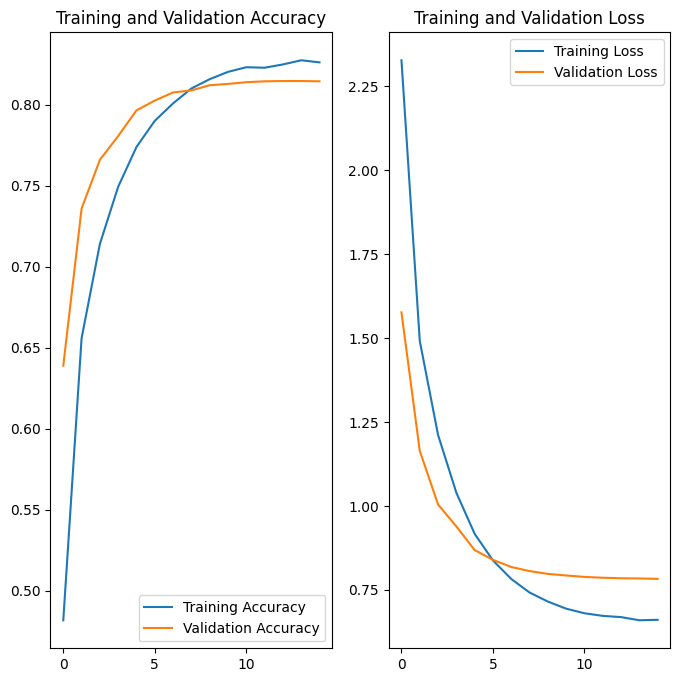

In [55]:
# 尝试加载已有的标签映射
TrainUtils().load_label_mapping(class_names=train_ds.class_names)

#绘制学习曲线
TrainUtils().plot_train_curve(history)


In [39]:
#记录模型
model.save("model_icondata_blur_gray_64.keras") 

#loaded_model = tf.keras.models.load_model("model_icondata_blur_gray_64.keras")

# 测试模型
#test_loss, test_acc = model.evaluate(prepproces_val_ds)
#print(f"Test accuracy: {test_acc}")



In [57]:
class_names = train_ds.class_names

def rgba_to_rgb(rgba, background=(255, 255, 255)):
        """
        将RGBA转换为RGB，使用指定背景色混合透明区域
        
        参数:
        rgba: RGBA张量 (uint8, 形状 [H, W, 4])
        background: 背景颜色 (R, G, B) 元组 (0-255)
        
        返回:
        RGB张量 (uint8, 形状 [H, W, 3])
        """
        # 分离通道
        rgb = rgba[..., :3]
        alpha = rgba[..., 3:]
        
        # 转换为float32进行混合计算
        rgb = tf.cast(rgb, tf.float32)
        alpha = tf.cast(alpha, tf.float32) / 255.0  # 归一化到[0,1]
        
        # 创建背景张量
        bg = tf.ones_like(rgb) * tf.constant(background, dtype=tf.float32)
        
        # 混合公式: 前景 * alpha + 背景 * (1 - alpha)
        blended = rgb * alpha + bg * (1.0 - alpha)
        
        # 转换回uint8
        return tf.cast(blended, tf.uint8)


test_dir = "test"

test_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]
print(test_paths)

def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 

    #归一化
    image = tf.image.convert_image_dtype(image, tf.float32)

    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)

    image = tf.squeeze(image)
    return image






test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image)
test_image_ds = test_image_ds.batch(32)

predictions = model.predict(test_image_ds)

plt.figure(figsize=(10,10))

for i in range(25):
    image = tf.io.read_file(test_paths[i])
    image = tf.image.decode_png(image, channels=4)
    image = utils.rgba_to_rgb(image)
    #print(image.shape, tf.reduce_max(image), tf.reduce_min(image))
    image = tf.image.resize(image, [img_height, img_width])
    
    #print(tf.reduce_max(image), tf.reduce_min(image))
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32)
    #高斯模糊 
    image = apply_gaussian_blur(image, kernel_size=3, sigma=0.5)
  
    image = tf.squeeze(image)
  
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap="gray")

    label=class_names[predicted_label]
    plt.xlabel(label)
plt.show()

['test/11_left-circle.png', 'test/399_arrow-left.png', 'test/setting4.png', 'test/407_download-cloud.png', 'test/3_check-square.png', 'test/setting3.png', 'test/setting2.png', 'test/36_file.png', 'test/setting1.png', 'test/160_arrow-down.png', 'test/157_arrow-up-circle.png', 'test/setting111.png', 'test/256_download.png', 'test/6728_download.png', 'test/238_arrow-right.png']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


AttributeError: module 'utils' has no attribute 'rgba_to_rgb'

<Figure size 1000x1000 with 0 Axes>